In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [12]:
def pmw(workload, x, eps=0.01, beta=0.1, k=0, show_messages=True, to_return='pd', ):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    sigma = 10 * math.log(1 / delta, np.e) * ((math.log(m, np.e)) ** (1 / 4)) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    y_list = [y_t]
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    algo_answers = []
    update_times = []
    d_t_hat_list = []
    # iterate through time = (0, k)
    for time, query in enumerate(workload):

        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=sigma, size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        d_t_hat_list.append(d_t_hat)
        #print("Current noisy distance:")
        #print(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold:
            #print("Lazy")
            algo_answers.append(np.dot(query, x_list[time]))
            x_list.append(x_list[time])
            update_list.append('no')
            continue

        # update round: update histogram and return noisy answer
        else:
            #print("update")
            update_list.append('yes')
            update_times.append(time)

            # step a
            if d_t_hat > 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            y_list.append(y_t)

            # step b
            x_t = y_t / np.sum(y_t)
            x_list.append(x_t)
        
        update_count = update_list.count('yes')
        
        print(f'{n * math.log(m, np.e) ** (1 / 2)=}')
        
        if update_count > n * math.log(m, np.e) ** (1 / 2):
            return "failure"
        else:
            algo_answers.append(a_t_hat / np.sum(x))

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(algo_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))

    def print_outputs():
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    
    if show_messages:
        print_outputs()
        plot_error()
        
    if to_return == "update_count":
        return update_count
    
    if to_return == "pd":
        d = {
            'queries': workload.tolist(), 
            'd_t_hat': d_t_hat_list, 
            'updated': update_list,
            'algo_ans': algo_answers,
            'real_ans': real_ans.tolist(),
            'abs_error': abs_error,               
            'rel_error': rel_error,
             }
        test_data = pd.DataFrame(data=d)
        return test_data

## General TODO:
Say we have a dataset [1,2,3,4,5,6,7]
Alice some random set of queries that only query indexes 1-4. Alice's queries come first and use all the budget. Practically that means alice runs queries unitl output = failure. Then Bob does queries on index 5-7 on the synthetic database. 

- Compare PMW with both Alice/Bob, and with just Alice and just bob. Calculate error difference. 
- Use a smaller database so the threshold is less
- Create a parallel list of people
- Split k and epsilon in half

In this case, Alice takes up all the privacy budget with her 450 queries only querying information from the first 4 indices of the database, resulting in the algorithm to print out "Failure".

the threshold for failure is 364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=364.8328023100234
n * math.log(m, np.e) ** (1 / 2)=36

,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-38.572682,yes,0.097539,0.090909,0.006630,0.072927
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.503138,no,0.000000,0.000000,0.000000,0.000000
2,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5.240360,no,0.387017,0.407115,0.020097,0.049365
3,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",5.866585,no,0.377403,0.403162,0.025759,0.063891
4,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",6.223245,no,0.377403,0.403162,0.025759,0.063891
...,...,...,...,...,...,...,...
445,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-164.582615,yes,0.349445,0.355731,0.006286,0.017671
446,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",93.824113,yes,0.370866,0.367589,0.003277,0.008914
447,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",79.548089,yes,0.314420,0.316206,0.001786,0.005648
448,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",12.415632,no,0.000009,0.047431,0.047422,0.999812


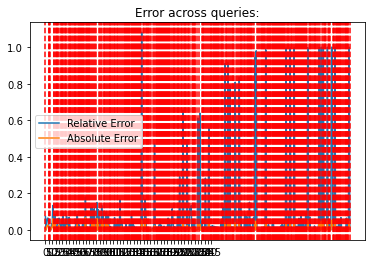

In [18]:
x_small = np.array([10, 80, 13, 12, 90, 14, 17, 17])
m = x_small.size  # database len
n = x_small.sum()
print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

alice_firstfour = np.random.randint(2, size=(450,4))
alice_lastfour = np.zeros((450,4))
alice = np.hstack((alice_firstfour, alice_lastfour))
bob = np.hstack((alice_lastfour, alice_firstfour))

pmw(workload=alice, x=x_small, eps=10, beta=0.1, k=450, to_return='pd')

In [ ]:
for total setting: set_beta=0.1, set_eps=0.01, k = 500

for separate setting: set_beta=0.1, set_eps=0.005, k = 250